In [28]:
import os
from glob import glob
import nbimporter
import pandas as pd
import numpy as np

from ResNet34 import ResnetBuilder
from DataParserForCNN import read_class, read_full_df, null_augment, drawing_to_image
from keras import backend as K
from DataParserForCNN import ImageBatchGenerator
from keras.utils import Sequence
from sklearn.metrics import confusion_matrix, classification_report

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def get_model(net, weight_path):
    
    if net == 'wavenet':
        wavenet_params = WaveNetParams()
        model = WaveNet(wavenet_params)
        
    elif net == 'resnet34':
        K.set_image_dim_ordering('tf')
        model = ResnetBuilder.build_resnet_34((3, 64, 64), 340)
    
    elif net == 'resnet50':
        K.set_image_dim_ordering('tf')
        model = ResnetBuilder.build_resnet_50((3, 64, 64), 340)
        
    model.load_weights(weight_path)
    
    return model

In [37]:
def evaluateTestSet(net, weight_path):
    result = model.evaluate(x_test, y_test, batch_size=2048)
    print('Accuracy: %2.1f%%, Top 3 Accuracy %2.1f%%' % (100*result[1], 100*result[2]))

In [11]:
model = get_model('resnet50', './model/qd_rn50_more38500_lb923.h5')

In [9]:
# base_path = 'C:/Users/IML/Desktop/QuickDrawDataset/'
base_path = '/Volumes/JS/QuickDraw/'
class_array = read_class()

In [10]:
full_df, train_id, valid_id = read_full_df(base_path, class_array)

	 load df   :  339/340                   zigzag  10 min 20 sec

	 load valid_set split:  339/340                   zigzag  15 min 00 sec

In [12]:
def normalize(image):
    return image / 255.

In [29]:
valid_batch = ImageBatchGenerator(class_array=class_array,
                                  full_df=full_df,
                                  datasplit_id=valid_id,
                                  split='valid_set',
                                  batch_size=128, 
                                  augment=null_augment, 
                                  mode='simplified', 
                                  norm=normalize,
                                  shuffle=False)

In [10]:
len(valid_batch[0])

2

In [68]:
from keras.optimizers import Adam
from keras.metrics import top_k_categorical_accuracy


def top_3_accuracy(y_true, y_pred): 
    return top_k_categorical_accuracy(y_true, y_pred, 3)


def map3(y_true, y_pred):
    return (top_k_categorical_accuracy(y_true, y_pred, 3) + top_k_categorical_accuracy(y_true, y_pred, 2)
            + top_k_categorical_accuracy(y_true, y_pred, 1)) / 3


def ap_3(y_true, y_pred):
    score = 0.0
    num_tp = 0.0
    
    if len(y_pred) > 3:
        y_pred = y_pred[:3]

    for i, p in enumerate(y_pred):
        if p in y_true and p not in y_pred[:i]:
            num_tp += 1.0
            score += num_tp / (i+1.0)

    if not y_truth:
        return 0.0
    
    return score / min(len(y_true), 3)


def map_3(y_true, y_pred):
    """ map average precision with maximum 3 predicted elements """
    return np.mean([ap_3(a, p) for a, p in zip(y_true, y_pred)])


optimizer = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='categorical_crossentropy', 
              metrics = ['accuracy', top_3_accuracy, map3],
              optimizer=optimizer)

In [69]:
result = model.evaluate_generator(valid_batch, verbose=1)

213/213 [==============================] - 449s 2s/step


In [70]:
print('Accuracy: %2.1f%%, Top 3 %2.1f%%, MAP@3 %2.1f%%' % (100*result[1], 100*result[2], 100*result[3]))

Accuracy: 81.9%, Top 3 93.6%, MAP@3 88.8%


In [34]:
def read_test_df(): 
    test_df = pd.read_csv('./test_%s.csv'%('simplified'))
#     test_id = np.arange(0, len(test_df))
    test_id = test_df['key_id'].values.astype(np.int64)

    return test_df, test_id

In [19]:
def get_valid_true():
    print(len(valid_id))
    valid_y = np.zeros((len(valid_id), 340), dtype='uint32')
    instance_count = 0
    for instance in valid_id:
        label, drawing_id, key_id = instance
        valid_y[instance_count, int(label)] = 1
        instance_count += 1
    return valid_y

In [20]:
test_df, test_id = read_test_df()

NameError: name 'read_test_df' is not defined

In [26]:
valid_y = get_valid_true()
print(valid_y[80])

27200
[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0]


In [13]:
class TestGenerator(Sequence):
    def __init__(self, 
                 test_df,
                 datasplit_id,
                 split='test_set',
                 augment=null_augment, 
                 batch_size=128,
                 mode='simplified',
                 norm=None,
                 shuffle=True):
        """ data: could be 'train' or 'test', the former used to get splited dataset train_set or valid_set, 
                  the latter used to get the TEST_DF
        """
        assert mode in ['simplified', 'raw']
        
        self.datasplit_id = datasplit_id
        self.split = split
        self.norm = norm
        self.df = test_df
        
        self.augment = augment
        self.batch_size = batch_size
        self.mode = mode 
        self.H, self.W = 64, 64

        num_class = 340

        print('')

        ### shuffle                    
        if shuffle:
            np.random.shuffle(self.datasplit_id)
        print('\n')

        
    def __str__(self):
        N = len(self.datasplit_id)
        string = ''\
        + '\tdata         = %s\n'%self.split \
        + '\tmode         = %s\n'%self.mode \
        + '\tlen(self.datasplit_id) = %d\n'%N \
        + '\n'
        return string


    def __getitem__(self, idx):
        if self.split == 'valid_set':
            l_bound = idx * self.batch_size
            r_bound = (idx + 1) * self.batch_size
            if r_bound > len(self.datasplit_id):
                r_bound = len(self.datasplit_id)
                l_bound = r_bound - self.batch_size
            instance_count = 0

            x_batch = np.zeros((r_bound-l_bound, self.H, self.W, 3))
            y_batch = np.zeros((r_bound-l_bound, 340), dtype='uint32')

            for instance in self.datasplit_id[l_bound:r_bound]:
                label, drawing_id, key_id = instance
                drawing = self.df[label]['drawing'][drawing_id]
                drawing = eval(drawing)

                image, label = self.augment(drawing, label, idx)

                x_batch[instance_count] = image
                y_batch[instance_count, int(label)] = 1

                if self.norm != None:
                    x_batch[instance_count] = self.norm(image)

                instance_count += 1
                
            return x_batch
            
        else:
            l_bound = idx * self.batch_size
            r_bound = (idx + 1) * self.batch_size
            
            if r_bound > len(self.datasplit_id):
                r_bound = len(self.datasplit_id)
                l_bound = r_bound - self.batch_size
            instance_count = 0

            x_batch = np.zeros((r_bound - l_bound, self.H, self.W, 3))
            
            for instance in self.datasplit_id[l_bound:r_bound]:
                drawing_id = instance
                drawing = self.df['drawing'][idx]
                drawing = eval(drawing)
                
                label = None
                image, label = self.augment(drawing, label, idx)
                
                x_batch[instance_count] = image
                
                if self.norm != None:
                    x_batch[instance_count] = self.norm(image)

                instance_count += 1

            return x_batch


    def __len__(self):
        return int(np.ceil(len(self.datasplit_id) / self.batch_size))

In [41]:
test_batch = TestGenerator(test_df, test_id, batch_size=1, norm=normalize, shuffle=False)

# Generate Sklearn Report

In [14]:
valid_batch = TestGenerator(full_df, valid_id, batch_size=1, split='valid_set', norm=normalize, shuffle=False)

In [15]:
valid_batch[0].shape

(1, 64, 64, 3)

In [65]:
np.array(test_batch[0][0]).shape

(64, 64, 3)

In [16]:
class_array = np.array(class_array)

In [27]:
valid_y_preds = model.predict_generator(valid_batch, verbose=True)

27200/27200 [==============================] - 1182s 43ms/step


In [71]:
def sklearnReportForValid():
    valid_true_cat = np.argmax(valid_y, 1)
    pred_cat = np.argmax(valid_y_preds, 1)
    plt.matshow(confusion_matrix(valid_true_cat, pred_cat))
    report = classification_report(valid_true_cat, pred_cat, 
                            target_names = [x for x in class_array])
    return report

In [49]:
pred_cat = np.argmax(valid_y_preds, 1)

In [55]:
valid_true_cat = np.argmax(valid_y, 1)

In [67]:
print(valid_true_cat[80:165])
print(pred_cat[80:165])
print(valid_true_cat[2000:2080])
print(pred_cat[2000:2080])
print(class_array[25])

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 2 2 2 2 2]
[ 17   1   1   1 150   1 173 179   1   1   1  58   1   1  92   1   1   1
  30   1   1 140 313   1   1   1  82   1 243   1 277 243 243   1  24 171
   1   1   1   1 213   1  24 243   1 243  58   1   1   1   1   1 171   1
 268   1   1   1   1   1   1   1   1 317   1   1   1 113   1 191   1   1
   1   1   1 243   1   1   1   1   2   2   2   2   2]
[25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25
 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25
 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25
 25 25 25 25 25 25 25 25]
[337  25 334  25  25  25  25  25  25 127 208 208 186 302 208  93  25  25
 302 279 186 302 302  25  25  93  25  25   4  25 127  93 302 186 271 186
  25  25 208  25  25  25 134 186  25  25 222  25 186  25  66  25  25  25
  25 302 161  25

                         precision    recall  f1-score   support

       The_Eiffel_Tower       0.96      0.91      0.94        80
The_Great_Wall_of_China       0.60      0.66      0.63        80
          The_Mona_Lisa       0.87      0.94      0.90        80
               airplane       0.91      0.91      0.91        80
            alarm_clock       0.94      0.91      0.92        80
              ambulance       0.82      0.84      0.83        80
                  angel       0.89      0.96      0.92        80
       animal_migration       0.73      0.82      0.78        80
                    ant       0.89      0.88      0.88        80
                  anvil       0.90      0.86      0.88        80
                  apple       0.94      0.90      0.92        80
                    arm       0.84      0.81      0.83        80
              asparagus       0.77      0.81      0.79        80
                    axe       0.96      0.86      0.91        80
               backpack 

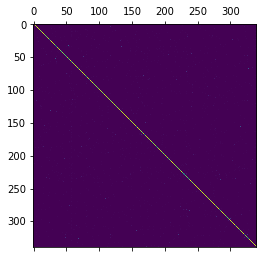

In [72]:
report = sklearnReportForValid()
print(report)

In [85]:
def classification_report_csv(report):
    report_data = []
    lines = report.split('\n')
    for line in lines[2:-3]:
        row = {}
        row_data = line.split('      ')
        row_data = list(filter(None, row_data))
        row['class'] = row_data[0]
        row['precision'] = float(row_data[1])
        row['recall'] = float(row_data[2])
        row['f1_score'] = float(row_data[3])
        row['support'] = float(row_data[4])
        report_data.append(row)
    dataframe = pd.DataFrame.from_dict(report_data)
    dataframe.to_csv('classification_report.csv', index = False)

In [86]:
classification_report_csv(report)

# Make a submission

In [170]:
test_id

array([9000003627287624, 9000010688666847, 9000023642890129, ...,
       9999968529902445, 9999969540362833, 9999996442242305])

In [51]:
test_y_preds = model.predict_generator(test_batch, verbose=True)

112199/112199 [==============================] - 2803s 25ms/step


In [52]:
top_3_predicition = [class_array[np.argsort(-1*pred)[:3]] for pred in test_y_preds]

In [53]:
top_3_predicition = np.squeeze(top_3_predicition)
top_3_predicition = [' '.join([col.replace(' ', '_') for col in row]) for row in top_3_predicition]

In [54]:
test_df['word'] = top_3_predicition

In [55]:
test_df[['key_id', 'word']].to_csv('rn50_2000_Ocb29.csv', index=False)